In [1]:
pwd()

"/home/bigcolin/Scripts/gplsim/quantile/qgplsim"

# Start

In [22]:
# run this ceil if source codes was edited
include("DGP.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra
using LaTeXStrings

import Base.Threads.@threads

# QGPLSIM fitting

In [37]:
# run this ceil for different data sets

α = [1.0, -0.5] # single index for x
θ = [1.0, 2.0] # linear for x, <α, θ> = 0 for identification
γ = [1.001, 0.5] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 300
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 0
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha, theta, gamma, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  9.852401 seconds (1.70 M allocations: 2.410 GiB, 14.99% gc time)
Estimation of index coefs: 
̂α => [1.0, -0.5]
̂γ => [0.7343488795201787, 0.44980756496988283]
Estimation of linear coefs: 
̂θ => [0.9928926957990883 1.9857853915981767]
̂β => [0.6987778821861627, -0.7790796795144234]


In [62]:
70^(-0.2)

0.4275435825099656

# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [ ]:
using Plots
# include("qgplsim.ji")

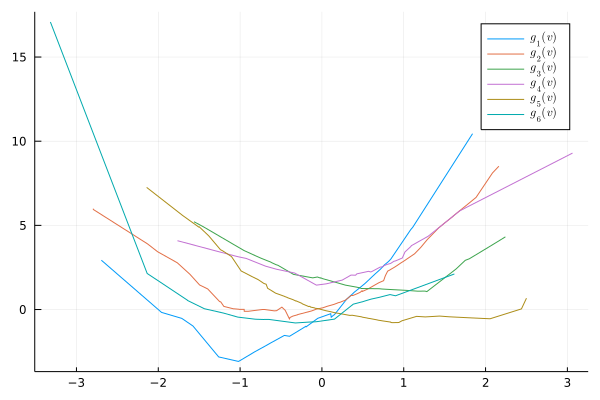

In [18]:

v = X * alpha # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y, -0.15) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

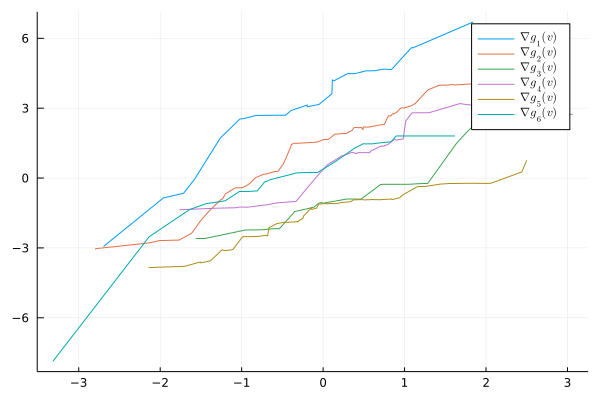

In [19]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [39]:
using DataFrames
df = DataFrame(α1 = Float64[], α2 = Float64[],
               var_α1 = Float64[], var_α2 = Float64[],    
               θ1 = Float64[], θ2 = Float64[],
               var_θ1 = Float64[], var_θ2 = Float64[], 
               β1 = Float64[], β2 = Float64[],
               var_β1 = Float64[], var_β2 = Float64[], 
               γ1 = Float64[], γ2 = Float64[],
               var_γ1 = Float64[], var_γ2 = Float64[])


,α1,α2,var_α1,var_α2,θ1,θ2,var_θ1,var_θ2,β1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [40]:
A = [:α1, :α2, :var_α1, :var_α2]
T = [:θ1, :θ2, :var_θ1, :var_θ2]
G = [:γ1, :γ2, :var_γ1, :var_γ2]
B = [:β1, :β2, :var_β1, :var_β2]

4-element Array{Symbol,1}:
 :β1
 :β2
 :var_β1
 :var_β2

In [41]:
Threads.nthreads()

12

In [49]:
include("MonteCarloSIM.ji")

simulation (generic function with 2 methods)

In [50]:
α = [1.0, 0.5] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
# γ = [1.0, 0.5] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 300
fx = 2
dist = 1 # Cauchy
alpha_type = 0

@threads for γ in [[1.0, 0.5], [1.0, 0.001], [0.001, 1.0], [0.5, 1.0],[0.5, 0.5], [0.0001, 0.0001]]
    res =  MonteCarlo(n, γ, θ, α, β, fx, dist, alpha_type)
    push!(df, res)
end

0.0%┣                                               ┫ 0/100 [00:00<00:-5, 0s/it]
0.0%┣                                               ┫ 0/100 [00:00<00:-5, 0s/it]
0.0%┣                                               ┫ 0/100 [00:00<00:-5, 0s/it]
0.0%0.0%┣┣  0.0%                                                                                            ┫ ┫ ┣0/100 [00:00<00:-5, 0s/it]0/100 [00:00<00:-5, 0s/it]

                                               ┫ 0/100 [00:00<00:-5, 0s/it]


LoadError: [91mTaskFailedException:[39m
[91m[91mDimensionMismatch("A has dimensions (300,2) but B has dimensions (1,2)")[39m[39m
[91mStacktrace:[39m
[91m [1] [1mgemm_wrapper![22m[1m([22m::Array{Float64,2}, ::Char, ::Char, ::Array{Float64,2}, ::Array{Float64,1}, ::LinearAlgebra.MulAddMul{true,true,Bool,Bool}[1m)[22m at [1m/buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/matmul.jl:569[22m[39m
[91m [2] [1mmul![22m at [1m/buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/matmul.jl:325[22m [inlined][39m
[91m [3] [1mmul![22m at [1m/buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/matmul.jl:208[22m [inlined][39m
[91m [4] [1m*[22m at [1m/buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/matmul.jl:153[22m [inlined][39m
[91m [5] [1mgamma_estimator[22m[1m([22m::Main.qgplsim.model, ::Array{Float64,1}, ::Array{Float64,1}[1m)[22m at [1m/home/bigcolin/Scripts/gplsim/quantile/qgplsim/qgplsim.ji:141[22m[39m
[91m [6] [1mestimator[22m[1m([22m::Main.qgplsim.model, ::Int64[1m)[22m at [1m/home/bigcolin/Scripts/gplsim/quantile/qgplsim/qgplsim.ji:48[22m[39m
[91m [7] [1mMonteCarlo[22m[1m([22m::Int64, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Int64, ::Int64, ::Int64[1m)[22m at [1m/home/bigcolin/Scripts/gplsim/quantile/qgplsim/MonteCarloSIM.ji:25[22m[39m
[91m [8] [1mmacro expansion[22m at [1m./In[50]:12[22m [inlined][39m
[91m [9] [1m(::var"#261#threadsfor_fun#6"{Array{Array{Float64,1},1}})[22m[1m([22m::Bool[1m)[22m at [1m./threadingconstructs.jl:81[22m[39m
[91m [10] [1m(::var"#261#threadsfor_fun#6"{Array{Array{Float64,1},1}})[22m[1m([22m[1m)[22m at [1m./threadingconstructs.jl:48[22m[39m

In [44]:
df[!, vcat(A, G)]

,α1,α2,var_α1,var_α2,γ1,γ2,var_γ1,var_γ2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,-0.5,0.0,0.0,0.474038,0.325033,0.141285,0.0798918
2,1.0,-0.5,0.0,0.0,0.276791,0.497286,0.141356,0.0692611
3,1.0,-0.5,0.0,0.0,0.099153,0.520663,0.124244,0.0743132
4,1.0,-0.5,0.0,0.0,0.630703,0.297349,0.159913,0.0622976


In [45]:
using CSV


In [46]:
CSV.write("gamma.csv", df)

"gamma.csv"